# Data Assimilation with GPS Data

This project demonstrates the Ensemble Kalman Filter (EnKF) using real GPS data procured from two phones measuring the location of the same thing (me driving my car around a parking lot). It is meant as a hands-on experience in overcoming each obstacle of real-world data assimilation, including asynchronous and irregularly-spaced observations that don't directly map to the timing of the state model, and obtaining a solid initial $\mathbf{R}$ matrix. The second issue is determining the accuracy of the model - for my case, I was able to make an approximate "true" solution by mapping out my route using an online tool. 

<img src = "../img/routes.png" height = 300 width = 300/>

## Plotting the observations

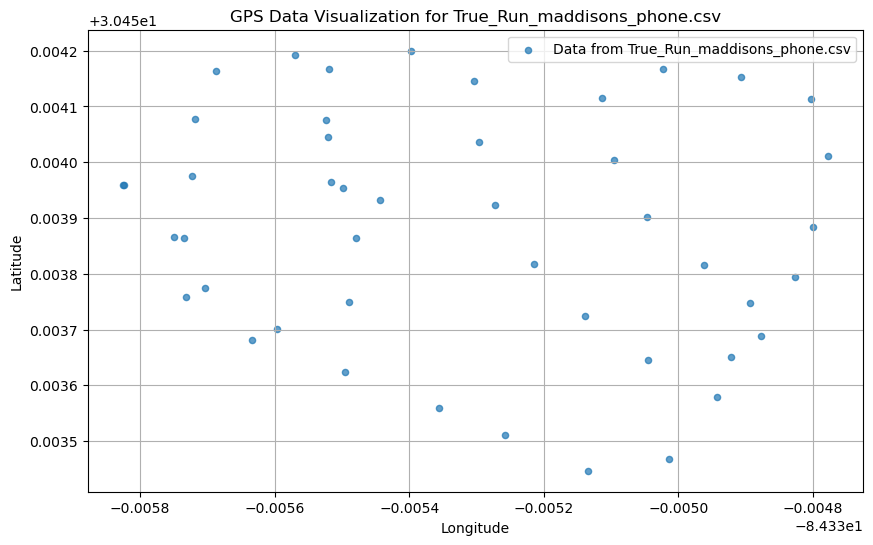

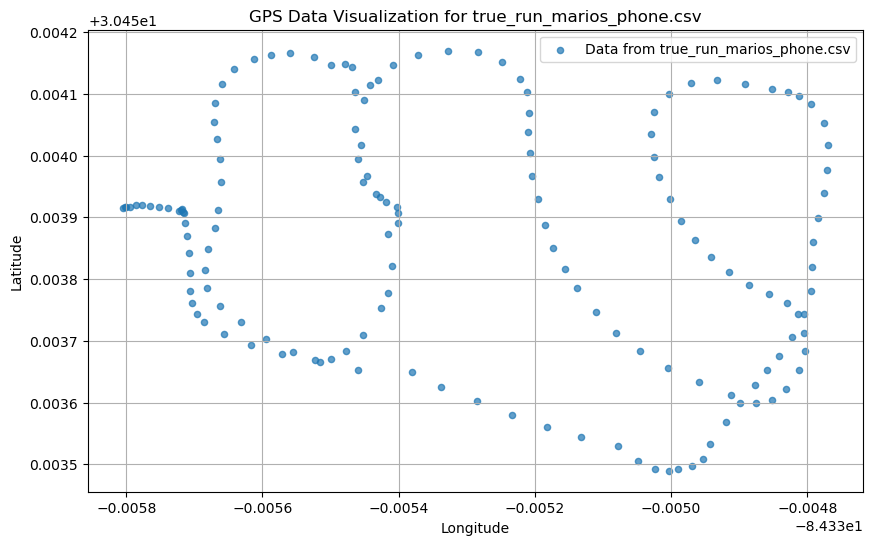

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_gps_data(file_path):
    # Load data
    data = pd.read_csv(file_path)
    
    latitudes = data['Latitude']
    longitudes = data['Longitude']

    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(longitudes, latitudes, alpha=0.7, marker='o', s=20, label=f'Data from {file_path.split("/")[-1]}')
    plt.title(f'GPS Data Visualization for {file_path.split("/")[-1]}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"../figs/{file_path.split('/')[-1].split('.')[0]}_original.png")
    plt.show()

# Paths to the datasets
mm_file_path = '../data/True_Run_maddisons_phone.csv'
ms_file_path = '../data/true_run_marios_phone.csv'

# Plotting each dataset
plot_gps_data(mm_file_path)
plot_gps_data(ms_file_path)


## Interpolating the observations

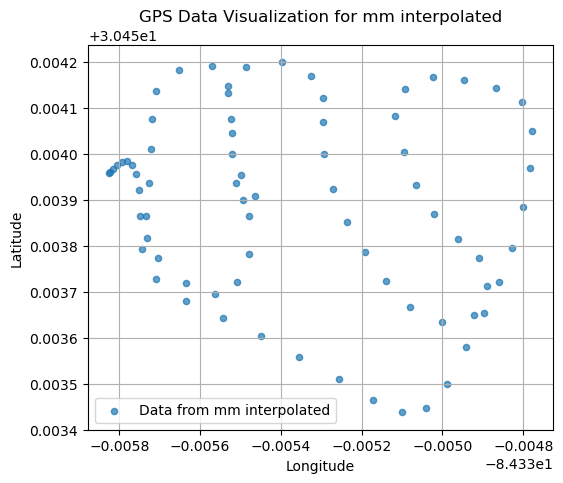

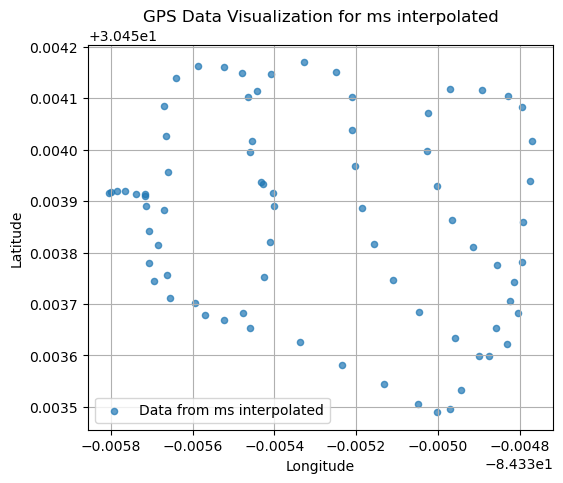

In [3]:
from scipy.interpolate import interp1d
import numpy as np

def interpolate_gps_data(file_path, freq='2s', method='linear'):
    # Load data
    data = pd.read_csv(file_path)
    
    # Strip off any irregular timezone strings and convert to datetime
    data['Datetime'] = data['Datetime'].str.slice(stop=-3)
    data['Datetime'] = pd.to_datetime(data['Datetime'], format='%Y/%m/%d %H:%M:%S', errors='coerce')
    
    # Set as index
    data.set_index('Datetime', inplace=True)
    
    # Trim data to remove leading/trailing NaNs in resampling
    data = data[~data['Longitude'].isna()]
    start, end = data.index.min(), data.index.max()

    # Resample within the data range
    data_resampled = data.resample(freq).interpolate(method=method)
    
    # If linear interpolation leaves NaNs, consider using spline for larger gaps
    if data_resampled.isna().any().any() and method == 'linear':
        # Create an interpolation function based on existing data points
        # Using time in seconds since the start for spline interpolation
        time_seconds = (data.index - start).total_seconds()
        spline_func_lon = interp1d(time_seconds, data['Longitude'], kind='cubic', fill_value="extrapolate")
        spline_func_lat = interp1d(time_seconds, data['Latitude'], kind='cubic', fill_value="extrapolate")
        
        # Create a new time index for resampling and interpolate
        freq_seconds = int(freq[:-1])  # Extract numerical part and convert to int
        new_time_index = np.arange(time_seconds[0], time_seconds[-1] + 1, freq_seconds)
        new_datetimes = [start + pd.Timedelta(seconds=int(sec)) for sec in new_time_index]
        
        longitude_interp = spline_func_lon(new_time_index)
        latitude_interp = spline_func_lat(new_time_index)
        
        data_resampled = pd.DataFrame({'Longitude': longitude_interp, 'Latitude': latitude_interp}, index=new_datetimes)

    return data_resampled

# Paths to the datasets
mm_file_path = '../data/True_Run_maddisons_phone.csv'
ms_file_path = '../data/True_run_marios_phone.csv'

# Interpolate each dataset, trying cubic spline if linear leaves NaNs
mm_resampled = interpolate_gps_data(mm_file_path, method='linear')
ms_resampled = interpolate_gps_data(ms_file_path, method='linear')

#save as csvs
mm_resampled.to_csv('../data/True_Run_maddisons_phone_resampled.csv')
ms_resampled.to_csv('../data/True_run_marios_phone_resampled.csv')

# Check the data format and extract coordinates
    # Assuming 'lat' and 'long' columns for Maddison's phone data
def plot_gps_data(data, name):
    latitudes = data['Latitude']
    longitudes = data['Longitude']


    # Create a scatter plot
    plt.figure(figsize=(6, 5))
    plt.scatter(longitudes, latitudes, alpha=0.7, marker='o', s=20, label=f'Data from {name}')
    plt.title(f'GPS Data Visualization for {name}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"../figs/{name}.png")
    plt.show()

# Plotting each dataset
plot_gps_data(mm_resampled, 'mm interpolated')
plot_gps_data(ms_resampled, 'ms interpolated')

## Generating the $\mathbf{R}$ matrix
Here, I logged the GPS at values without moving position, allowing me to see the variability in the observations. From this, we derive the $\mathbf{R}$ matrix.

In [6]:
def generate_R(data):
    """ Generate R matrix from provided DataFrame """
    variance_longitude = data['Longitude'].var()
    variance_latitude = data['Latitude'].var()
    covariance_lat_lon = data['Latitude'].cov(data['Longitude'])
    return np.array([[variance_latitude, covariance_lat_lon],
                     [covariance_lat_lon, variance_longitude]])

def calculate_cross_covariance(data1, data2):
    """ Calculate cross-covariance between two data sources """
    covariance_lat1_lat2 = data1['Latitude'].cov(data2['Latitude'])
    covariance_lon1_lon2 = data1['Longitude'].cov(data2['Longitude'])
    covariance_lat1_lon2 = data1['Latitude'].cov(data2['Longitude'])
    covariance_lon1_lat2 = data1['Longitude'].cov(data2['Latitude'])
    return np.array([[covariance_lat1_lat2, covariance_lat1_lon2],
                     [covariance_lon1_lat2, covariance_lon1_lon2]])

# Generate R matrices for each resampled dataset
R_mm = generate_R(mm_resampled)
R_ms = generate_R(ms_resampled)

# Calculate cross-covariance matrix for the observations between resampled datasets
R_cross = calculate_cross_covariance(mm_resampled, ms_resampled)

# Construct the combined R matrix with cross-covariances
R_combined = np.block([
    [R_mm, R_cross],
    [R_cross.T, R_ms]
])
# remove nans
R_combined = np.nan_to_num(R_combined)

print("Combined R Matrix with Cross-Correlation:")
print(R_combined)


Combined R Matrix with Cross-Correlation:
[[ 4.15034576e-08 -1.38941408e-08  0.00000000e+00  0.00000000e+00]
 [-1.38941408e-08  1.09911504e-07  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.63864452e-08 -1.48852484e-08]
 [ 0.00000000e+00  0.00000000e+00 -1.48852484e-08  1.13572062e-07]]


## Stochastic Ensemble Kalman Filter

In [7]:
class EnsembleKalmanFilter:
    def __init__(self, initial_state, ensemble_size, R, Q, model, H, dt=1):
        self.ensemble_size = ensemble_size
        self.states = np.array([initial_state + np.random.multivariate_normal(np.zeros(len(initial_state)), Q) for _ in range(ensemble_size)])
        self.R = R  # Observation error covariance matrix
        self.Q = Q  # Process noise covariance matrix
        self.model = model  # Model function
        self.H = H  # Observation matrix
        self.dt = dt  # Time step for the model

    def predict(self):
        """ Propagate all ensemble members through the model. """
        for i in range(self.ensemble_size):
            model_noise = np.random.multivariate_normal(np.zeros(len(self.states[i])), self.Q)
            self.states[i] = self.model(self.states[i], self.dt) + model_noise

    def update(self, observation):
        """ Update ensemble members based on observation. """
        # Generate perturbed observations
        perturbed_observations = [observation + np.random.multivariate_normal(np.zeros(len(observation)), self.R) for _ in range(self.ensemble_size)]
        
        # Calculate ensemble mean and covariance
        mean_forecast = np.mean(self.states, axis=0)
        cov_forecast = np.cov(self.states, rowvar=False)
        
        # Calculate Kalman gain
        PfHT = cov_forecast @ self.H.T
        HPfHT = self.H @ PfHT + self.R
        Kalman_gain = PfHT @ np.linalg.inv(HPfHT)
        
        # Update each ensemble member
        for i in range(self.ensemble_size):
            innovation = perturbed_observations[i] - self.H @ self.states[i]
            self.states[i] += Kalman_gain @ innovation

    def get_state_estimate(self):
        """ Return the current state estimate (ensemble mean). """
        return np.mean(self.states, axis=0)

def model(state, dt):
    """ Example model that just returns the same state (identity model). """
    return state

def run(ensemble_size):
    initial_state = np.array([-84.33577932,30.45390741])
    R = R_combined  # Observation error
    Q = np.diag([0.1, 0.1])  # Process noise
    H = np.array([[1,0],[0,1],[1,0],[0,1]]) # Observing all elements of the state

    # Creating the EnKF instance
    enkf = EnsembleKalmanFilter(initial_state, ensemble_size, R, Q, model, H)

    df1 = pd.read_csv('../data/madds_observations.csv')
    df2 = pd.read_csv('../data/mario_observations.csv')
    observations_df = pd.concat([df1,df2], axis=1)


    # Store the state estimates for each time step
    state_estimates = []

    # Iterate through each observation in the DataFrame
    for index, row in observations_df.iterrows():
        observation = row.values
        enkf.predict()  # Predict the next state
        enkf.update(observation)  # Update based on new observation
        state_estimate = enkf.get_state_estimate()  # Get the current state estimate
        state_estimates.append(state_estimate)  # Store the state estimate

    # Convert state_estimates to a DataFrame for easier handling
    state_estimates_df = pd.DataFrame(state_estimates, columns=['Estimated Longitude', 'Estimated Latitude'])

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(state_estimates_df['Estimated Longitude'], state_estimates_df['Estimated Latitude'], 'r-', label='Estimated Path')
    plt.scatter(observations_df['Longitude1'], observations_df['Latitude1'], c='b', alpha=0.5, label='Sensor 1 Observations')
    plt.scatter(observations_df['Longitude2'], observations_df['Latitude2'], c='g', alpha=0.5, label='Sensor 2 Observations')
    plt.title(f'EnKF Estimated Path vs Sensor Observations {ensemble_size} members')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.savefig(f"../figs/EnKF_estimated_path_{ensemble_size}.png")
    plt.show()

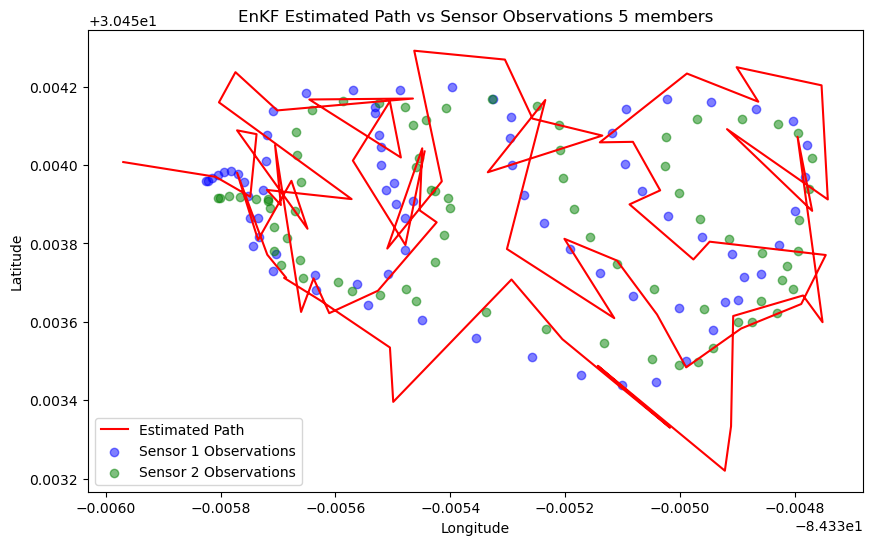

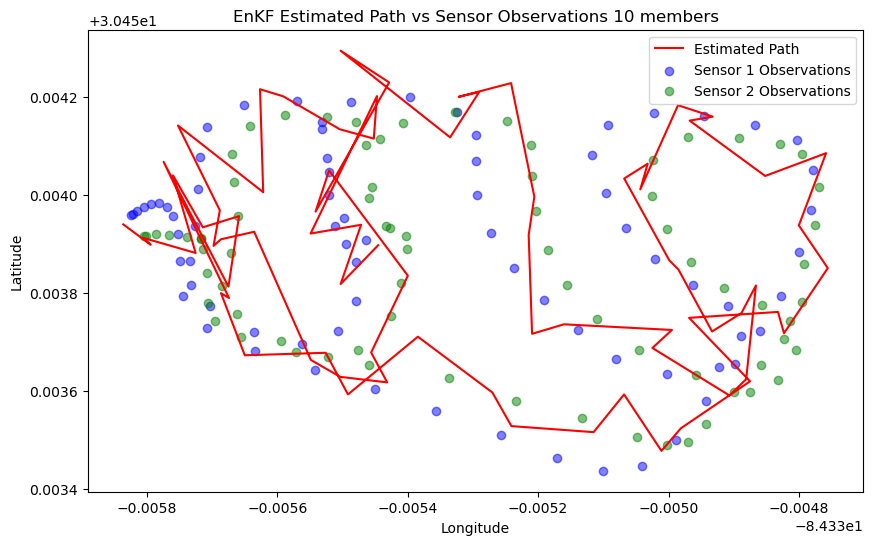

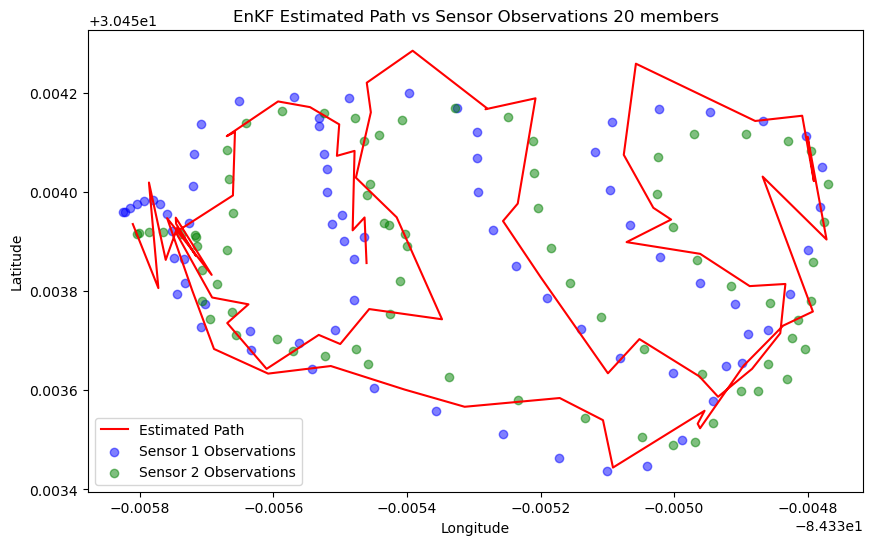

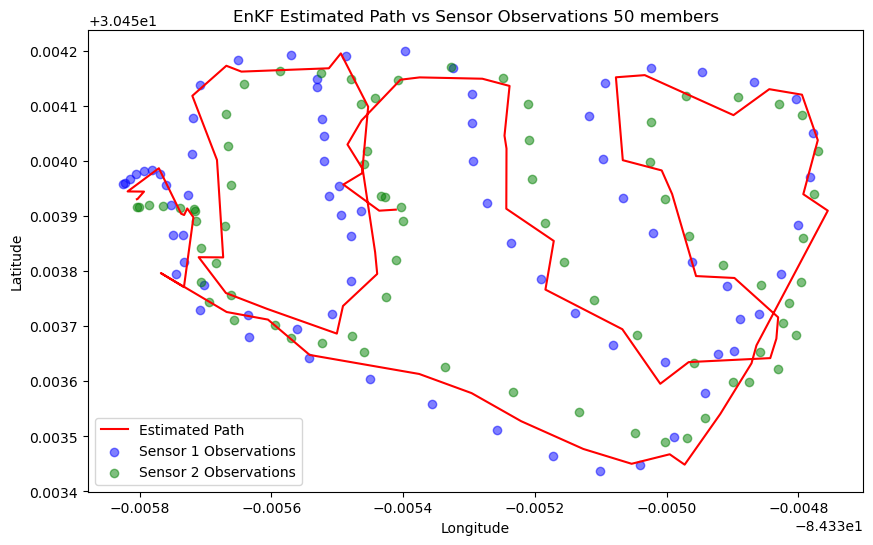

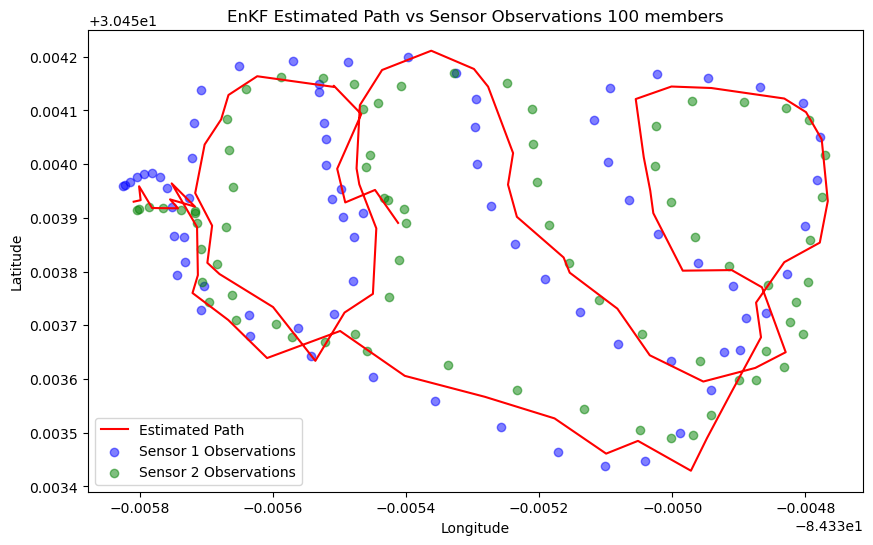

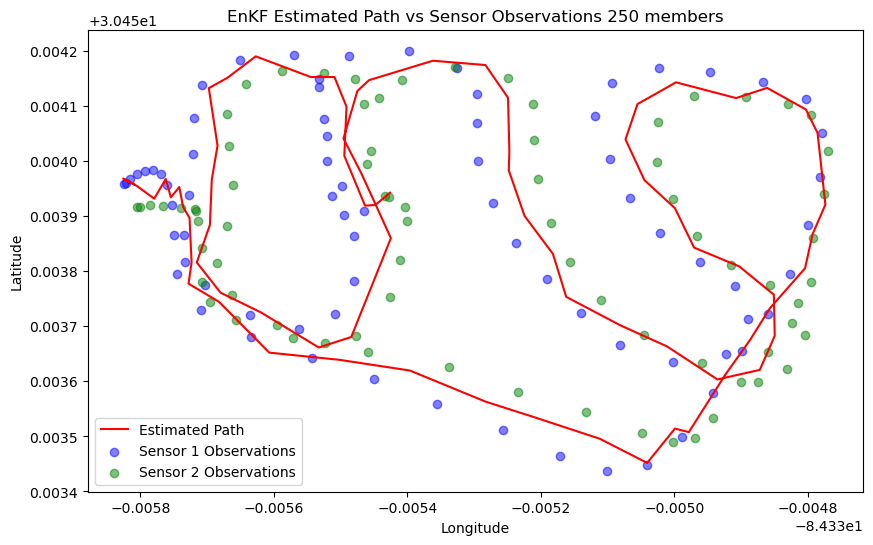

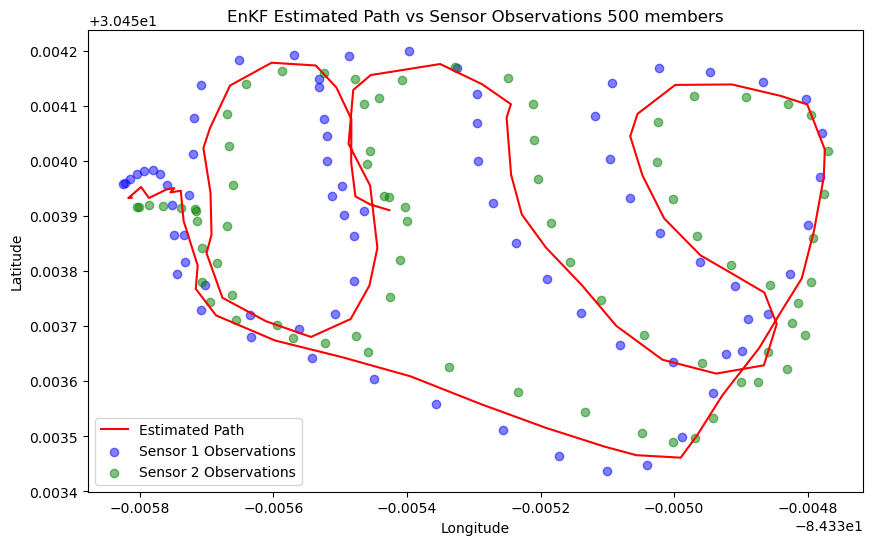

In [8]:
ensembles = [5,10,20,50,100,250,500]
for ensemble_size in ensembles:
    run(ensemble_size)